In [1]:
import os
import sys
import numpy as np
import pandas as pd
import re
from prophet import Prophet
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from sktime.forecasting.arima import AutoARIMA
import pandas as pd
from sktime.forecasting.model_selection import temporal_train_test_split
from sktime.forecasting.arima import AutoARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error


c:\Users\aditi\miniconda3\envs\dai\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Importing plotly failed. Interactive plots will not work.


In [2]:
df = pd.read_csv('air-traffic-prediction/parkingLot.csv')

Performed the necessary data preprocessing 

In [3]:
df['timestamp'] = pd.to_datetime(df['timestamp'])
df = df.sort_values(by='timestamp')
df = df[df['vehicle_no'].notna()]
df = df.dropna()
df = df[(df['timestamp'].dt.hour >= 5) & (df['timestamp'].dt.hour < 24)]
df = df.drop_duplicates()

In [4]:
entry_df = df[df['camera_id'] == 1]  # Entries (camera_id = 001)
exit_df = df[df['camera_id'] == 2]   # Exits (camera_id = 002)

# Rename columns for clarity
entry_df = entry_df.rename(columns={'timestamp': 'in_time'})
exit_df = exit_df.rename(columns={'timestamp': 'exit_time'})
merged_df = pd.merge(entry_df[['vehicle_no', 'in_time']], 
                    exit_df[['vehicle_no', 'exit_time']], 
                    on='vehicle_no', 
                    how='left')

merged_df['in_time'] = pd.to_datetime(merged_df['in_time'])
merged_df['timestamp_exit'] = pd.to_datetime(arg=merged_df['exit_time'])

# Ensure timestamps are on the same date by comparing just the date part
merged_df = merged_df[
    (merged_df['in_time'].dt.date == merged_df['exit_time'].dt.date) &
    (merged_df['in_time'] <= merged_df['exit_time'])
]
merged_df= merged_df.dropna()
merged_df['in_time'] = pd.to_datetime(merged_df['in_time'])
merged_df['date'] = merged_df['in_time'].dt.date
merged_df

,vehicle_no,in_time,exit_time,timestamp_exit,date
0,MHUN7063,2024-09-12 05:00:00,2024-09-12 08:00:00,2024-09-12 08:00:00,2024-09-12
1,MHMY1867,2024-09-12 05:00:00,2024-09-12 09:20:00,2024-09-12 09:20:00,2024-09-12
2,MHZF8417,2024-09-12 05:00:00,2024-09-12 09:20:00,2024-09-12 09:20:00,2024-09-12
3,MHFU6425,2024-09-12 05:00:00,2024-09-12 09:40:00,2024-09-12 09:40:00,2024-09-12
4,MHHB4038,2024-09-12 05:00:00,2024-09-12 09:20:00,2024-09-12 09:20:00,2024-09-12
...,...,...,...,...,...
53311,MHBU1695,2024-11-13 19:20:00,2024-11-13 23:40:00,2024-11-13 23:40:00,2024-11-13
53312,MHFL6897,2024-11-13 19:20:00,2024-11-13 23:40:00,2024-11-13 23:40:00,2024-11-13
53313,MHFO0975,2024-11-13 19:20:00,2024-11-13 23:40:00,2024-11-13 23:40:00,2024-11-13
53314,MHSY4044,2024-11-13 19:40:00,2024-11-13 23:40:00,2024-11-13 23:40:00,2024-11-13


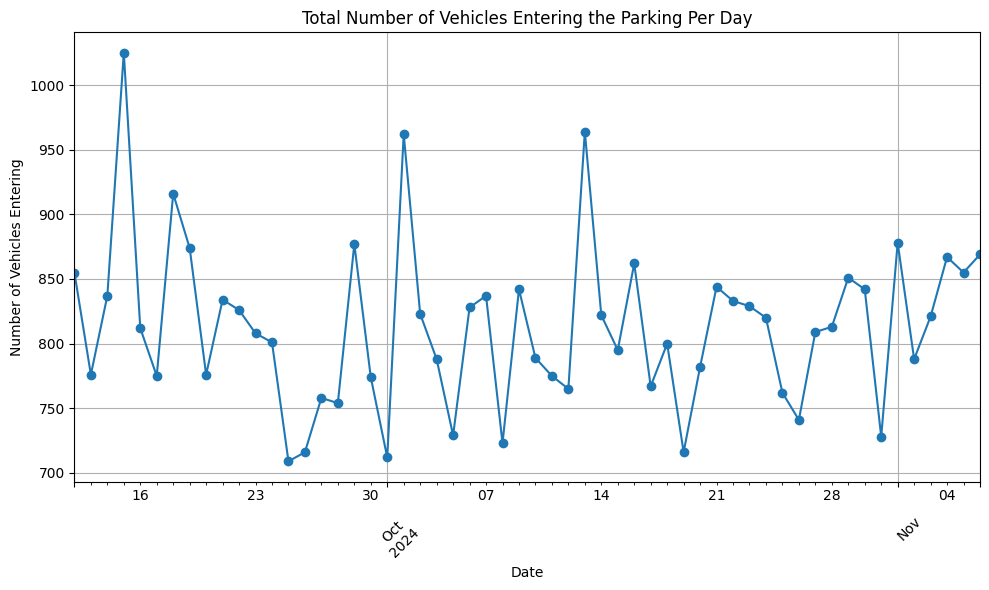

In [5]:

# Group by 'date' and count the number of entries per day
entries_daily = merged_df.groupby('date')['vehicle_no'].count()
entries_daily.index = pd.to_datetime(entries_daily.index)


# Sort the data by date (this step ensures it's chronological)
entries_daily = entries_daily.sort_index()
entries_daily = entries_daily.reindex(pd.date_range(start=entries_daily.index.min(), 
                                              end=entries_daily.index.max(), 
                                              freq='D')).fillna(method='ffill')
#  Split the data into train and test sets
# Use all but the last 7 days for training, and the last 7 days for testing
train_data = entries_daily.iloc[:-7]  # All data except the last 7 days
test_data = entries_daily.iloc[-7:] 

# 3. Plot the total number of vehicles entering per day
plt.figure(figsize=(10, 6))
train_data.plot(kind='line', marker='o')
plt.title('Total Number of Vehicles Entering the Parking Per Day')
plt.xlabel('Date')
plt.ylabel('Number of Vehicles Entering')
plt.grid(True)
plt.xticks(rotation=45)  # Rotate date labels for better readability
plt.tight_layout()
plt.show()

In [6]:
def mean_absolute_scaled_error(y_true, y_pred):
    """
    Calculate Mean Absolute Scaled Error (MASE).
    
    :param y_true: Array-like, true values
    :param y_pred: Array-like, predicted values
    :return: float, MASE value
    """
    # Calculate the mean absolute error (MAE)
    mae = mean_absolute_error(y_true, y_pred)

    # Calculate the naive forecast errors
    naive_forecast = np.roll(y_true.astype(float), 1)  # Ensure it's float
    naive_forecast[0] = np.nan  # First value has no naive forecast
    naive_error = np.abs(y_true - naive_forecast)

    # Calculate the mean absolute error of the naive forecast (MAE)
    mae_naive = np.nanmean(naive_error)  # Ignore NaN values in the calculation
    
    # Calculate MASE
    mase = mae / mae_naive if mae_naive != 0 else np.nan  # Handle division by zero
    
    return mase


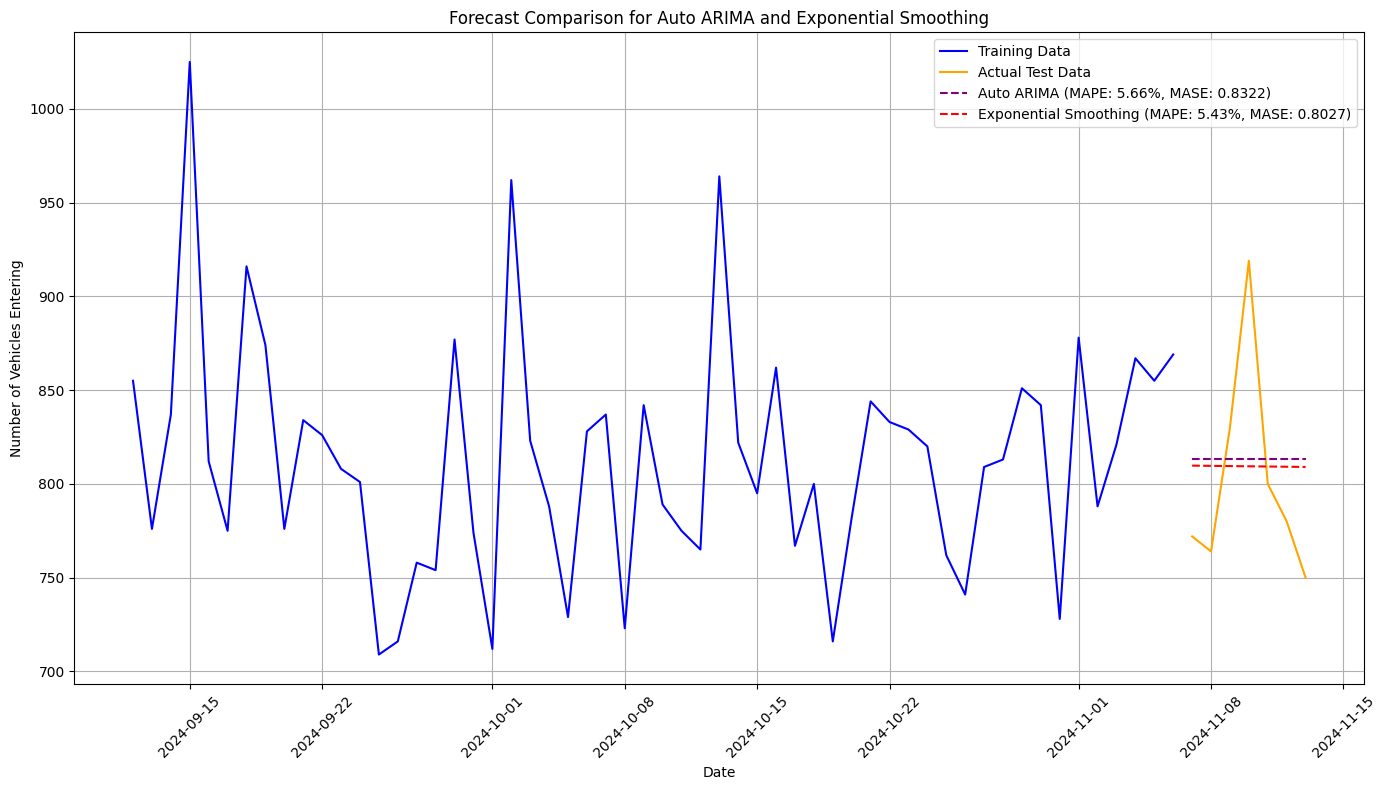

In [7]:


def forecasting_autoarima_expsmoothing(train_data, test_data):
    # Auto ARIMA Model
    model_auto_arima = AutoARIMA(sp=30, suppress_warnings=True, seasonal=True)
    model_auto_arima.fit(train_data)
    forecast_auto_arima = model_auto_arima.predict(fh=[i for i in range(1, 8)])
    mase_arima = mean_absolute_scaled_error(y_true=test_data, y_pred=forecast_auto_arima)
    mape_arima = mean_absolute_percentage_error(test_data, forecast_auto_arima)

    # Exponential Smoothing Model
    exp_smoothing_model = ExponentialSmoothing(train_data, trend='add', seasonal=None).fit()
    forecast_exp_smoothing = exp_smoothing_model.forecast(steps=7)
    mase_exp_smoothing = mean_absolute_scaled_error(y_true=test_data, y_pred=forecast_exp_smoothing)
    mape_exp_smoothing = mean_absolute_percentage_error(test_data, forecast_exp_smoothing)

    # Plot combined graph for Auto ARIMA and Exponential Smoothing
    plt.figure(figsize=(14, 8))
    plt.plot(train_data.index, train_data, label="Training Data", color='blue')
    plt.plot(test_data.index, test_data, label="Actual Test Data", color='orange')

    plt.plot(test_data.index, forecast_auto_arima, label=f"Auto ARIMA (MAPE: {mape_arima:.2%}, MASE: {mase_arima:.4f})", linestyle='--', color='purple')
    plt.plot(test_data.index, forecast_exp_smoothing, label=f"Exponential Smoothing (MAPE: {mape_exp_smoothing:.2%}, MASE: {mase_exp_smoothing:.4f})", linestyle='--', color='red')

    plt.title('Forecast Comparison for Auto ARIMA and Exponential Smoothing')
    plt.xlabel('Date')
    plt.ylabel('Number of Vehicles Entering')
    plt.xticks(rotation=45)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

forecasting_autoarima_expsmoothing(train_data, test_data)


From the errors reported by MAPE and MASE we can clearly see that Exponential Smoothing gives the best results followed by AUTO Arima. I just used sarima and prophet to check the accuracy of them though that was not recomended

c:\Users\aditi\miniconda3\envs\dai\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Users\aditi\miniconda3\envs\dai\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
c:\Users\aditi\miniconda3\envs\dai\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
c:\Users\aditi\miniconda3\envs\dai\Lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
19:20:07 - cmdstanpy

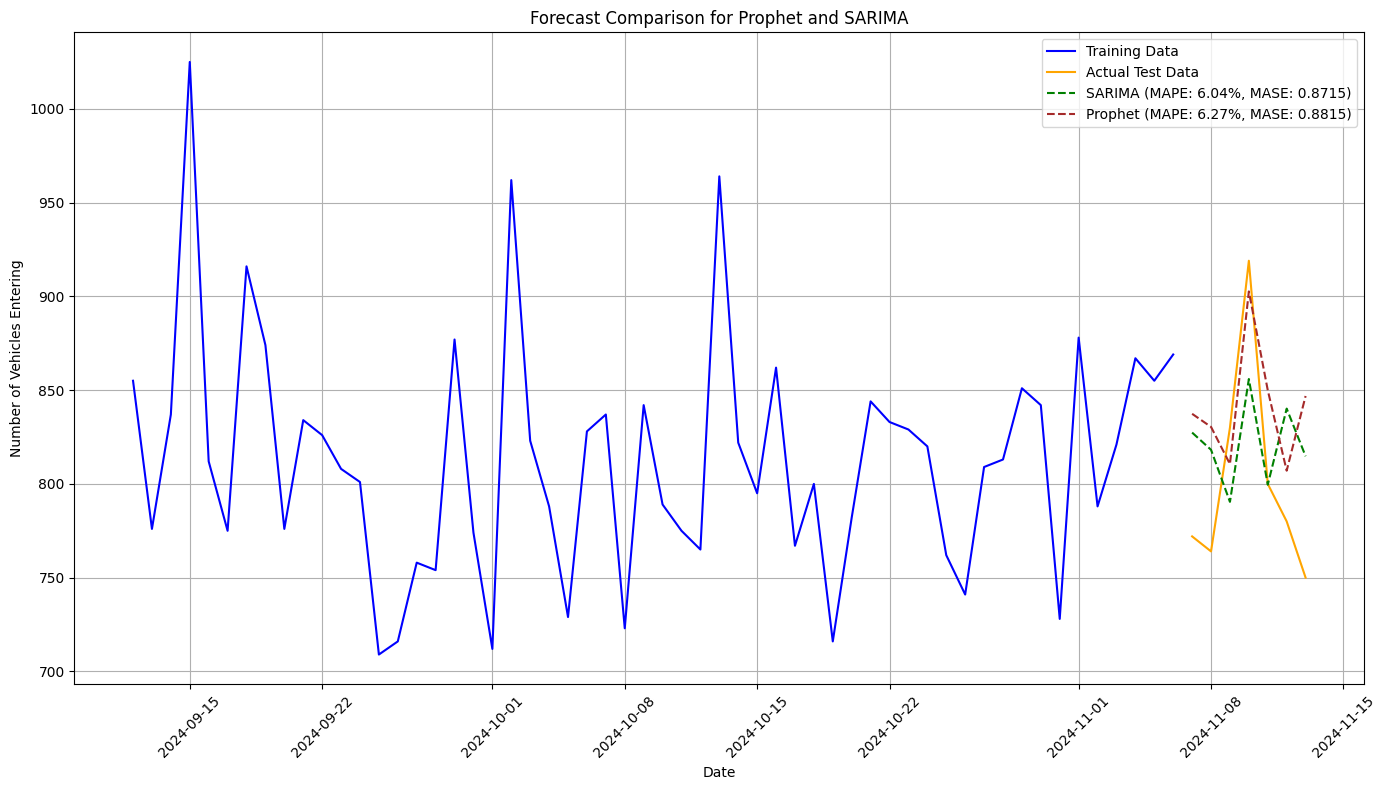

In [8]:
def forecasting_prophet_sarima(train_data, test_data):
    # SARIMA Model
    sarima_model = SARIMAX(train_data, order=(4,4,5), seasonal_order=(1,1,2,7))
    sarima_fit = sarima_model.fit(disp=False)
    forecast_sarima = sarima_fit.forecast(steps=7)
    mase_sarima = mean_absolute_scaled_error(y_true=test_data, y_pred=forecast_sarima)
    mape_sarima = mean_absolute_percentage_error(test_data, forecast_sarima)

    # Prophet Model
    prophet_data = train_data.reset_index()
    prophet_data.columns = ["ds", "y"]
    prophet_model = Prophet(yearly_seasonality=True, weekly_seasonality=True, daily_seasonality=False)
    prophet_model.fit(prophet_data)
    future = prophet_model.make_future_dataframe(periods=7)
    forecast_prophet = prophet_model.predict(future)['yhat'][-7:].values
    mase_prophet = mean_absolute_scaled_error(y_true=test_data, y_pred=forecast_prophet)
    mape_prophet = mean_absolute_percentage_error(test_data, forecast_prophet)

    # Plot combined graph for Prophet and SARIMA
    plt.figure(figsize=(14, 8))
    plt.plot(train_data.index, train_data, label="Training Data", color='blue')
    plt.plot(test_data.index, test_data, label="Actual Test Data", color='orange')

    plt.plot(test_data.index, forecast_sarima, label=f"SARIMA (MAPE: {mape_sarima:.2%}, MASE: {mase_sarima:.4f})", linestyle='--', color='green')
    plt.plot(test_data.index, forecast_prophet, label=f"Prophet (MAPE: {mape_prophet:.2%}, MASE: {mase_prophet:.4f})", linestyle='--', color='brown')

    plt.title('Forecast Comparison for Prophet and SARIMA')
    plt.xlabel('Date')
    plt.ylabel('Number of Vehicles Entering')
    plt.xticks(rotation=45)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

forecasting_prophet_sarima(train_data, test_data)


These two seem to give a better fit but still there accuracy is not good.